In [1]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features

In [2]:
dataset_path = 'data/data_speech_commands_v0.02'

In [3]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
all_targets.remove('bella')
print(all_targets)

['zero', 'four', 'three', 'right', 'cat', 'tree', 'happy', 'one', 'wow', 'up', 'down', 'house', 'marvin', 'two', 'yes', 'nine', 'bird', 'learn', 'sheila', 'dog', 'bed', 'eight', 'on', 'stop', 'left', 'forward', 'six', 'off', 'visual', 'five', 'backward', 'go', 'no', 'seven', 'follow']


In [4]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

4052
3728
3727
3778
2031
1759
2054
3890
2123
3723
3917
2113
2100
3880
4044
3934
2064
1575
2022
2128
2014
3787
3845
3972
3801
1557
3860
3745
1592
4052
1664
3980
3941
3998
1579
Total samples: 106029


In [5]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16

In [6]:
# max_samples_per_word = 530

In [7]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    files = listdir(join(dataset_path, target)) # [:max_samples_per_word]
    print(f"Adding {len(files)} samples")
    filenames.append(files)
    y.append(np.ones(len(filenames[index])) * index)

data/data_speech_commands_v0.02/zero
Adding 4052 samples
data/data_speech_commands_v0.02/four
Adding 3728 samples
data/data_speech_commands_v0.02/three
Adding 3727 samples
data/data_speech_commands_v0.02/right
Adding 3778 samples
data/data_speech_commands_v0.02/cat
Adding 2031 samples
data/data_speech_commands_v0.02/tree
Adding 1759 samples
data/data_speech_commands_v0.02/happy
Adding 2054 samples
data/data_speech_commands_v0.02/one
Adding 3890 samples
data/data_speech_commands_v0.02/wow
Adding 2123 samples
data/data_speech_commands_v0.02/up
Adding 3723 samples
data/data_speech_commands_v0.02/down
Adding 3917 samples
data/data_speech_commands_v0.02/house
Adding 2113 samples
data/data_speech_commands_v0.02/marvin
Adding 2100 samples
data/data_speech_commands_v0.02/two
Adding 3880 samples
data/data_speech_commands_v0.02/yes
Adding 4044 samples
data/data_speech_commands_v0.02/nine
Adding 3934 samples
data/data_speech_commands_v0.02/bird
Adding 2064 samples
data/data_speech_commands_v0.02/

In [8]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [9]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [10]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

106029
106029


In [11]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [12]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [13]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [14]:
def signal_to_mfcc(signal, fs):
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [15]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    return signal_to_mfcc(signal, fs)

In [16]:
# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1

Dropped: 11 (16, 9)
Dropped: 37 (16, 12)
Dropped: 39 (16, 14)
Dropped: 50 (16, 11)
Dropped: 61 (16, 7)
Dropped: 63 (16, 11)
Dropped: 78 (16, 12)
Dropped: 82 (16, 13)
Dropped: 97 (16, 15)
Dropped: 138 (16, 15)
Dropped: 146 (16, 9)
Dropped: 147 (16, 13)
Dropped: 148 (16, 11)
Dropped: 169 (16, 15)
Dropped: 181 (16, 13)
Dropped: 215 (16, 11)
Dropped: 216 (16, 10)
Dropped: 226 (16, 10)
Dropped: 232 (16, 13)
Dropped: 254 (16, 12)
Dropped: 261 (16, 11)
Dropped: 272 (16, 15)
Dropped: 273 (16, 15)
Dropped: 276 (16, 11)
Dropped: 278 (16, 13)
Dropped: 285 (16, 13)
Dropped: 289 (16, 13)
Dropped: 297 (16, 10)
Dropped: 303 (16, 15)
Dropped: 305 (16, 15)
Dropped: 332 (16, 11)
Dropped: 339 (16, 12)
Dropped: 372 (16, 8)
Dropped: 383 (16, 11)
Dropped: 417 (16, 11)
Dropped: 443 (16, 10)
Dropped: 445 (16, 10)
Dropped: 450 (16, 13)
Dropped: 465 (16, 13)
Dropped: 467 (16, 7)
Dropped: 489 (16, 13)
Dropped: 491 (16, 11)


In [17]:
print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 0.084


MFCCs: [[-6.45585362e+01 -6.42844276e+01 -6.38236521e+01 -5.87258053e+01
  -3.71017708e+01 -2.37265057e+01 -1.69617173e+01 -1.57302691e+01
  -1.88545268e+01 -2.12763732e+01 -2.01911693e+01 -2.09012958e+01
  -2.50137477e+01 -3.13284498e+01 -3.60585022e+01 -4.03671959e+01]
 [ 6.94851395e+00  7.23110884e+00  6.45369867e+00  5.55121950e+00
   1.34645082e+01  1.41358882e+01  1.34079537e+01  1.33077347e+01
   1.40745255e+01  1.46225409e+01  1.32868022e+01  1.21740374e+01
   1.25587117e+01  1.44354702e+01  1.59934110e+01  1.63192298e+01]
 [ 2.04311169e+00  2.41547806e+00  2.50511329e+00  2.58914186e-01
  -2.71563081e+00 -3.68156804e+00 -4.18445663e+00 -3.96361184e+00
  -3.09339789e+00 -3.00769982e+00 -4.05845507e+00 -4.44745171e+00
  -4.30224513e+00 -4.13908220e+00 -3.33662330e+00 -2.58025183e+00]
 [ 3.47480784e+00  3.58295567e+00  3.13304075e+00  2.66713743e+00
  -3.57749138e+00 -3.91258782e+00 -3.58437553e+00 -3.41417232e+00
  -3.16961201e+00 -1.62683451e+00  7.66672750e-01  1.67073063e+00


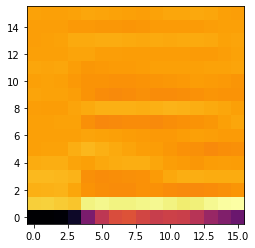

In [18]:
# TEST: Test shorter MFCC
# !pip install playsound
from playsound import playsound

idx = 13

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
playsound(path)

In [19]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [20]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Dropped: 11 (16, 9)
Dropped: 37 (16, 12)
Dropped: 39 (16, 14)
Dropped: 50 (16, 11)
Dropped: 61 (16, 7)
Dropped: 63 (16, 11)
Dropped: 78 (16, 12)
Dropped: 82 (16, 13)
Dropped: 97 (16, 15)
Dropped: 138 (16, 15)
Dropped: 146 (16, 9)
Dropped: 147 (16, 13)
Dropped: 148 (16, 11)
Dropped: 169 (16, 15)
Dropped: 181 (16, 13)
Dropped: 215 (16, 11)
Dropped: 216 (16, 10)
Dropped: 226 (16, 10)
Dropped: 232 (16, 13)
Dropped: 254 (16, 12)
Dropped: 261 (16, 11)
Dropped: 272 (16, 15)
Dropped: 273 (16, 15)
Dropped: 276 (16, 11)
Dropped: 278 (16, 13)
Dropped: 285 (16, 13)
Dropped: 289 (16, 13)
Dropped: 297 (16, 10)
Dropped: 303 (16, 15)
Dropped: 305 (16, 15)
Dropped: 332 (16, 11)
Dropped: 339 (16, 12)
Dropped: 372 (16, 8)
Dropped: 383 (16, 11)
Dropped: 417 (16, 11)
Dropped: 443 (16, 10)
Dropped: 445 (16, 10)
Dropped: 450 (16, 13)
Dropped: 465 (16, 13)
Dropped: 467 (16, 7)
Dropped: 489 (16, 13)
Dropped: 491 (16, 11)
Dropped: 521 (16, 12)
Dropped: 525 (16, 15)
Dropped: 555 (16, 15)
Dropped: 556 (16, 13)
Dr

Dropped: 4114 (16, 14)
Dropped: 4128 (16, 8)
Dropped: 4153 (16, 14)
Dropped: 4167 (16, 14)
Dropped: 4171 (16, 15)
Dropped: 4186 (16, 9)
Dropped: 4193 (16, 14)
Dropped: 4198 (16, 10)
Dropped: 4217 (16, 12)
Dropped: 4232 (16, 13)
Dropped: 4260 (16, 10)
Dropped: 4262 (16, 6)
Dropped: 4263 (16, 10)
Dropped: 4265 (16, 12)
Dropped: 4285 (16, 11)
Dropped: 4291 (16, 8)
Dropped: 4296 (16, 14)
Dropped: 4313 (16, 11)
Dropped: 4335 (16, 7)
Dropped: 4340 (16, 10)
Dropped: 4344 (16, 9)
Dropped: 4348 (16, 7)
Dropped: 4370 (16, 15)
Dropped: 4382 (16, 14)
Dropped: 4383 (16, 12)
Dropped: 4393 (16, 15)
Dropped: 4408 (16, 13)
Dropped: 4410 (16, 11)
Dropped: 4430 (16, 11)
Dropped: 4441 (16, 15)
Dropped: 4448 (16, 13)
Dropped: 4459 (16, 9)
Dropped: 4486 (16, 14)
Dropped: 4498 (16, 14)
Dropped: 4511 (16, 11)
Dropped: 4512 (16, 11)
Dropped: 4537 (16, 13)
Dropped: 4588 (16, 12)
Dropped: 4592 (16, 14)
Dropped: 4606 (16, 15)
Dropped: 4633 (16, 11)
Dropped: 4662 (16, 13)
Dropped: 4671 (16, 12)
Dropped: 4683 (16, 

Dropped: 8415 (16, 10)
Dropped: 8416 (16, 13)
Dropped: 8430 (16, 14)
Dropped: 8472 (16, 11)
Dropped: 8477 (16, 14)
Dropped: 8492 (16, 13)
Dropped: 8494 (16, 14)
Dropped: 8495 (16, 9)
Dropped: 8509 (16, 13)
Dropped: 8529 (16, 14)
Dropped: 8536 (16, 6)
Dropped: 8555 (16, 13)
Dropped: 8556 (16, 12)
Dropped: 8563 (16, 11)
Dropped: 8570 (16, 8)
Dropped: 8583 (16, 13)
Dropped: 8584 (16, 11)
Dropped: 8591 (16, 7)
Dropped: 8595 (16, 11)
Dropped: 8608 (16, 13)
Dropped: 8610 (16, 12)
Dropped: 8615 (16, 13)
Dropped: 8618 (16, 13)
Dropped: 8620 (16, 13)
Dropped: 8627 (16, 11)
Dropped: 8650 (16, 12)
Dropped: 8660 (16, 6)
Dropped: 8665 (16, 14)
Dropped: 8666 (16, 13)
Dropped: 8675 (16, 7)
Dropped: 8698 (16, 15)
Dropped: 8707 (16, 11)
Dropped: 8720 (16, 11)
Dropped: 8727 (16, 12)
Dropped: 8738 (16, 14)
Dropped: 8797 (16, 13)
Dropped: 8814 (16, 15)
Dropped: 8834 (16, 13)
Dropped: 8853 (16, 12)
Dropped: 8863 (16, 15)
Dropped: 8867 (16, 14)
Dropped: 8890 (16, 7)
Dropped: 8894 (16, 6)
Dropped: 8900 (16, 

Dropped: 12626 (16, 12)
Dropped: 12648 (16, 7)
Dropped: 12658 (16, 11)
Dropped: 12664 (16, 10)
Dropped: 12676 (16, 9)
Dropped: 12686 (16, 13)
Dropped: 12706 (16, 14)
Dropped: 12733 (16, 15)
Dropped: 12735 (16, 7)
Dropped: 12742 (16, 13)
Dropped: 12748 (16, 11)
Dropped: 12753 (16, 7)
Dropped: 12759 (16, 10)
Dropped: 12764 (16, 8)
Dropped: 12775 (16, 15)
Dropped: 12776 (16, 13)
Dropped: 12778 (16, 15)
Dropped: 12779 (16, 11)
Dropped: 12783 (16, 10)
Dropped: 12785 (16, 10)
Dropped: 12793 (16, 7)
Dropped: 12794 (16, 6)
Dropped: 12797 (16, 12)
Dropped: 12798 (16, 13)
Dropped: 12808 (16, 5)
Dropped: 12811 (16, 14)
Dropped: 12815 (16, 10)
Dropped: 12827 (16, 10)
Dropped: 12828 (16, 11)
Dropped: 12835 (16, 11)
Dropped: 12844 (16, 14)
Dropped: 12846 (16, 10)
Dropped: 12866 (16, 14)
Dropped: 12873 (16, 14)
Dropped: 12878 (16, 11)
Dropped: 12891 (16, 15)
Dropped: 12897 (16, 7)
Dropped: 12912 (16, 13)
Dropped: 12926 (16, 14)
Dropped: 12935 (16, 15)
Dropped: 12939 (16, 14)
Dropped: 12941 (16, 12)
D

Dropped: 16976 (16, 14)
Dropped: 16978 (16, 12)
Dropped: 16990 (16, 13)
Dropped: 16998 (16, 9)
Dropped: 17005 (16, 12)
Dropped: 17034 (16, 11)
Dropped: 17039 (16, 4)
Dropped: 17042 (16, 12)
Dropped: 17066 (16, 13)
Dropped: 17072 (16, 15)
Dropped: 17080 (16, 14)
Dropped: 17088 (16, 11)
Dropped: 17092 (16, 13)
Dropped: 17095 (16, 11)
Dropped: 17130 (16, 15)
Dropped: 17138 (16, 10)
Dropped: 17144 (16, 14)
Dropped: 17169 (16, 14)
Dropped: 17170 (16, 10)
Dropped: 17183 (16, 9)
Dropped: 17199 (16, 15)
Dropped: 17219 (16, 10)
Dropped: 17220 (16, 11)
Dropped: 17223 (16, 11)
Dropped: 17241 (16, 12)
Dropped: 17253 (16, 13)
Dropped: 17278 (16, 12)
Dropped: 17295 (16, 13)
Dropped: 17296 (16, 15)
Dropped: 17298 (16, 14)
Dropped: 17299 (16, 15)
Dropped: 17307 (16, 11)
Dropped: 17312 (16, 15)
Dropped: 17318 (16, 9)
Dropped: 17334 (16, 14)
Dropped: 17336 (16, 13)
Dropped: 17346 (16, 7)
Dropped: 17354 (16, 10)
Dropped: 17377 (16, 9)
Dropped: 17379 (16, 7)
Dropped: 17393 (16, 15)
Dropped: 17398 (16, 13)

Dropped: 21030 (16, 12)
Dropped: 21034 (16, 11)
Dropped: 21045 (16, 13)
Dropped: 21050 (16, 13)
Dropped: 21081 (16, 8)
Dropped: 21085 (16, 15)
Dropped: 21088 (16, 14)
Dropped: 21093 (16, 13)
Dropped: 21111 (16, 3)
Dropped: 21117 (16, 13)
Dropped: 21119 (16, 11)
Dropped: 21127 (16, 10)
Dropped: 21135 (16, 11)
Dropped: 21139 (16, 8)
Dropped: 21150 (16, 15)
Dropped: 21157 (16, 13)
Dropped: 21172 (16, 11)
Dropped: 21176 (16, 14)
Dropped: 21183 (16, 15)
Dropped: 21205 (16, 11)
Dropped: 21208 (16, 11)
Dropped: 21218 (16, 15)
Dropped: 21264 (16, 11)
Dropped: 21265 (16, 13)
Dropped: 21290 (16, 13)
Dropped: 21298 (16, 11)
Dropped: 21331 (16, 13)
Dropped: 21336 (16, 8)
Dropped: 21342 (16, 14)
Dropped: 21355 (16, 10)
Dropped: 21361 (16, 11)
Dropped: 21363 (16, 7)
Dropped: 21367 (16, 13)
Dropped: 21371 (16, 9)
Dropped: 21378 (16, 8)
Dropped: 21380 (16, 14)
Dropped: 21415 (16, 9)
Dropped: 21432 (16, 14)
Dropped: 21440 (16, 14)
Dropped: 21458 (16, 8)
Dropped: 21463 (16, 10)
Dropped: 21499 (16, 14)
D

Dropped: 25033 (16, 15)
Dropped: 25060 (16, 13)
Dropped: 25065 (16, 4)
Dropped: 25070 (16, 7)
Dropped: 25078 (16, 8)
Dropped: 25083 (16, 8)
Dropped: 25109 (16, 14)
Dropped: 25144 (16, 11)
Dropped: 25172 (16, 15)
Dropped: 25189 (16, 8)
Dropped: 25199 (16, 11)
Dropped: 25212 (16, 11)
Dropped: 25215 (16, 10)
Dropped: 25219 (16, 8)
Dropped: 25225 (16, 15)
Dropped: 25251 (16, 12)
Dropped: 25257 (16, 4)
Dropped: 25266 (16, 13)
Dropped: 25295 (16, 9)
Dropped: 25298 (16, 15)
Dropped: 25301 (16, 12)
Dropped: 25339 (16, 8)
Dropped: 25360 (16, 15)
Dropped: 25370 (16, 15)
Dropped: 25405 (16, 12)
Dropped: 25413 (16, 11)
Dropped: 25414 (16, 12)
Dropped: 25443 (16, 15)
Dropped: 25444 (16, 8)
Dropped: 25458 (16, 13)
Dropped: 25484 (16, 13)
Dropped: 25486 (16, 13)
Dropped: 25487 (16, 12)
Dropped: 25491 (16, 15)
Dropped: 25503 (16, 15)
Dropped: 25517 (16, 11)
Dropped: 25547 (16, 14)
Dropped: 25552 (16, 11)
Dropped: 25554 (16, 11)
Dropped: 25574 (16, 13)
Dropped: 25580 (16, 9)
Dropped: 25595 (16, 11)
Dro

Dropped: 29011 (16, 15)
Dropped: 29022 (16, 11)
Dropped: 29023 (16, 8)
Dropped: 29044 (16, 12)
Dropped: 29048 (16, 14)
Dropped: 29051 (16, 13)
Dropped: 29070 (16, 11)
Dropped: 29071 (16, 14)
Dropped: 29082 (16, 13)
Dropped: 29085 (16, 13)
Dropped: 29086 (16, 11)
Dropped: 29091 (16, 13)
Dropped: 29092 (16, 13)
Dropped: 29096 (16, 13)
Dropped: 29107 (16, 15)
Dropped: 29110 (16, 13)
Dropped: 29115 (16, 15)
Dropped: 29152 (16, 14)
Dropped: 29157 (16, 9)
Dropped: 29177 (16, 15)
Dropped: 29191 (16, 14)
Dropped: 29197 (16, 10)
Dropped: 29206 (16, 11)
Dropped: 29207 (16, 15)
Dropped: 29221 (16, 14)
Dropped: 29228 (16, 11)
Dropped: 29234 (16, 8)
Dropped: 29248 (16, 14)
Dropped: 29252 (16, 11)
Dropped: 29257 (16, 13)
Dropped: 29258 (16, 14)
Dropped: 29266 (16, 12)
Dropped: 29277 (16, 7)
Dropped: 29281 (16, 14)
Dropped: 29295 (16, 11)
Dropped: 29323 (16, 11)
Dropped: 29327 (16, 13)
Dropped: 29341 (16, 8)
Dropped: 29365 (16, 13)
Dropped: 29368 (16, 10)
Dropped: 29370 (16, 13)
Dropped: 29373 (16, 1

Dropped: 33012 (16, 13)
Dropped: 33034 (16, 12)
Dropped: 33042 (16, 12)
Dropped: 33068 (16, 6)
Dropped: 33072 (16, 13)
Dropped: 33078 (16, 8)
Dropped: 33087 (16, 12)
Dropped: 33090 (16, 8)
Dropped: 33104 (16, 11)
Dropped: 33123 (16, 7)
Dropped: 33129 (16, 7)
Dropped: 33152 (16, 14)
Dropped: 33174 (16, 13)
Dropped: 33179 (16, 11)
Dropped: 33185 (16, 13)
Dropped: 33200 (16, 13)
Dropped: 33210 (16, 13)
Dropped: 33223 (16, 15)
Dropped: 33230 (16, 11)
Dropped: 33296 (16, 13)
Dropped: 33313 (16, 12)
Dropped: 33331 (16, 12)
Dropped: 33334 (16, 11)
Dropped: 33339 (16, 3)
Dropped: 33346 (16, 13)
Dropped: 33354 (16, 15)
Dropped: 33356 (16, 13)
Dropped: 33359 (16, 10)
Dropped: 33393 (16, 9)
Dropped: 33398 (16, 10)
Dropped: 33422 (16, 15)
Dropped: 33446 (16, 14)
Dropped: 33497 (16, 14)
Dropped: 33516 (16, 13)
Dropped: 33534 (16, 11)
Dropped: 33552 (16, 13)
Dropped: 33556 (16, 13)
Dropped: 33559 (16, 12)
Dropped: 33563 (16, 11)
Dropped: 33570 (16, 14)
Dropped: 33590 (16, 15)
Dropped: 33603 (16, 10)

Dropped: 37010 (16, 11)
Dropped: 37037 (16, 15)
Dropped: 37041 (16, 15)
Dropped: 37067 (16, 13)
Dropped: 37068 (16, 15)
Dropped: 37074 (16, 9)
Dropped: 37076 (16, 11)
Dropped: 37080 (16, 12)
Dropped: 37082 (16, 13)
Dropped: 37095 (16, 9)
Dropped: 37097 (16, 15)
Dropped: 37108 (16, 13)
Dropped: 37117 (16, 15)
Dropped: 37154 (16, 13)
Dropped: 37160 (16, 15)
Dropped: 37178 (16, 6)
Dropped: 37179 (16, 7)
Dropped: 37185 (16, 12)
Dropped: 37217 (16, 15)
Dropped: 37243 (16, 14)
Dropped: 37251 (16, 13)
Dropped: 37260 (16, 12)
Dropped: 37266 (16, 14)
Dropped: 37269 (16, 14)
Dropped: 37273 (16, 14)
Dropped: 37309 (16, 12)
Dropped: 37336 (16, 9)
Dropped: 37338 (16, 15)
Dropped: 37339 (16, 15)
Dropped: 37353 (16, 15)
Dropped: 37379 (16, 13)
Dropped: 37403 (16, 13)
Dropped: 37431 (16, 12)
Dropped: 37474 (16, 14)
Dropped: 37515 (16, 6)
Dropped: 37517 (16, 13)
Dropped: 37518 (16, 11)
Dropped: 37528 (16, 11)
Dropped: 37548 (16, 13)
Dropped: 37588 (16, 8)
Dropped: 37609 (16, 9)
Dropped: 37615 (16, 14)


Dropped: 41247 (16, 13)
Dropped: 41256 (16, 11)
Dropped: 41264 (16, 14)
Dropped: 41271 (16, 13)
Dropped: 41299 (16, 15)
Dropped: 41305 (16, 13)
Dropped: 41306 (16, 13)
Dropped: 41314 (16, 15)
Dropped: 41332 (16, 8)
Dropped: 41352 (16, 14)
Dropped: 41357 (16, 15)
Dropped: 41367 (16, 11)
Dropped: 41390 (16, 12)
Dropped: 41409 (16, 14)
Dropped: 41413 (16, 12)
Dropped: 41417 (16, 9)
Dropped: 41435 (16, 13)
Dropped: 41437 (16, 13)
Dropped: 41445 (16, 11)
Dropped: 41447 (16, 15)
Dropped: 41453 (16, 15)
Dropped: 41469 (16, 10)
Dropped: 41472 (16, 7)
Dropped: 41486 (16, 12)
Dropped: 41487 (16, 14)
Dropped: 41497 (16, 14)
Dropped: 41511 (16, 12)
Dropped: 41519 (16, 14)
Dropped: 41522 (16, 11)
Dropped: 41529 (16, 13)
Dropped: 41581 (16, 10)
Dropped: 41583 (16, 14)
Dropped: 41585 (16, 11)
Dropped: 41588 (16, 12)
Dropped: 41589 (16, 15)
Dropped: 41616 (16, 8)
Dropped: 41639 (16, 9)
Dropped: 41645 (16, 8)
Dropped: 41676 (16, 11)
Dropped: 41702 (16, 13)
Dropped: 41710 (16, 10)
Dropped: 41721 (16, 9)

Dropped: 45466 (16, 15)
Dropped: 45472 (16, 10)
Dropped: 45483 (16, 14)
Dropped: 45517 (16, 15)
Dropped: 45518 (16, 14)
Dropped: 45542 (16, 14)
Dropped: 45567 (16, 12)
Dropped: 45601 (16, 7)
Dropped: 45616 (16, 9)
Dropped: 45619 (16, 12)
Dropped: 45623 (16, 12)
Dropped: 45651 (16, 12)
Dropped: 45699 (16, 10)
Dropped: 45711 (16, 11)
Dropped: 45713 (16, 15)
Dropped: 45714 (16, 10)
Dropped: 45731 (16, 15)
Dropped: 45762 (16, 13)
Dropped: 45772 (16, 9)
Dropped: 45784 (16, 15)
Dropped: 45788 (16, 9)
Dropped: 45797 (16, 11)
Dropped: 45804 (16, 10)
Dropped: 45810 (16, 15)
Dropped: 45823 (16, 11)
Dropped: 45870 (16, 10)
Dropped: 45899 (16, 10)
Dropped: 45907 (16, 6)
Dropped: 45911 (16, 13)
Dropped: 45912 (16, 14)
Dropped: 45924 (16, 15)
Dropped: 45926 (16, 10)
Dropped: 45962 (16, 14)
Dropped: 45968 (16, 12)
Dropped: 46014 (16, 6)
Dropped: 46020 (16, 13)
Dropped: 46026 (16, 12)
Dropped: 46031 (16, 14)
Dropped: 46036 (16, 13)
Dropped: 46038 (16, 13)
Dropped: 46067 (16, 8)
Dropped: 46070 (16, 13)

Dropped: 49362 (16, 9)
Dropped: 49373 (16, 11)
Dropped: 49391 (16, 15)
Dropped: 49401 (16, 15)
Dropped: 49405 (16, 11)
Dropped: 49412 (16, 13)
Dropped: 49424 (16, 13)
Dropped: 49440 (16, 15)
Dropped: 49443 (16, 7)
Dropped: 49460 (16, 14)
Dropped: 49479 (16, 13)
Dropped: 49480 (16, 11)
Dropped: 49495 (16, 9)
Dropped: 49502 (16, 12)
Dropped: 49514 (16, 7)
Dropped: 49515 (16, 11)
Dropped: 49521 (16, 15)
Dropped: 49544 (16, 11)
Dropped: 49562 (16, 13)
Dropped: 49594 (16, 13)
Dropped: 49598 (16, 14)
Dropped: 49610 (16, 8)
Dropped: 49616 (16, 10)
Dropped: 49623 (16, 13)
Dropped: 49642 (16, 8)
Dropped: 49667 (16, 11)
Dropped: 49672 (16, 5)
Dropped: 49675 (16, 15)
Dropped: 49685 (16, 5)
Dropped: 49698 (16, 11)
Dropped: 49702 (16, 12)
Dropped: 49703 (16, 10)
Dropped: 49705 (16, 15)
Dropped: 49712 (16, 9)
Dropped: 49713 (16, 11)
Dropped: 49720 (16, 15)
Dropped: 49730 (16, 8)
Dropped: 49736 (16, 11)
Dropped: 49751 (16, 10)
Dropped: 49758 (16, 12)
Dropped: 49790 (16, 15)
Dropped: 49803 (16, 14)
Dr

Dropped: 53605 (16, 11)
Dropped: 53611 (16, 7)
Dropped: 53617 (16, 13)
Dropped: 53618 (16, 13)
Dropped: 53620 (16, 14)
Dropped: 53625 (16, 11)
Dropped: 53627 (16, 12)
Dropped: 53631 (16, 11)
Dropped: 53642 (16, 12)
Dropped: 53679 (16, 11)
Dropped: 53680 (16, 12)
Dropped: 53686 (16, 15)
Dropped: 53694 (16, 11)
Dropped: 53703 (16, 9)
Dropped: 53727 (16, 14)
Dropped: 53763 (16, 12)
Dropped: 53768 (16, 15)
Dropped: 53774 (16, 12)
Dropped: 53795 (16, 11)
Dropped: 53817 (16, 13)
Dropped: 53825 (16, 11)
Dropped: 53837 (16, 15)
Dropped: 53856 (16, 15)
Dropped: 53865 (16, 11)
Dropped: 53893 (16, 6)
Dropped: 53894 (16, 15)
Dropped: 53903 (16, 12)
Dropped: 53910 (16, 15)
Dropped: 53921 (16, 4)
Dropped: 53926 (16, 14)
Dropped: 53928 (16, 13)
Dropped: 53930 (16, 12)
Dropped: 53937 (16, 15)
Dropped: 53941 (16, 14)
Dropped: 53959 (16, 15)
Dropped: 53964 (16, 6)
Dropped: 53966 (16, 15)
Dropped: 53972 (16, 14)
Dropped: 53989 (16, 8)
Dropped: 53996 (16, 12)
Dropped: 53998 (16, 14)
Dropped: 54020 (16, 15

Dropped: 57384 (16, 11)
Dropped: 57389 (16, 13)
Dropped: 57397 (16, 10)
Dropped: 57417 (16, 12)
Dropped: 57422 (16, 2)
Dropped: 57423 (16, 10)
Dropped: 57425 (16, 8)
Dropped: 57436 (16, 11)
Dropped: 57439 (16, 14)
Dropped: 57440 (16, 15)
Dropped: 57449 (16, 14)
Dropped: 57452 (16, 11)
Dropped: 57454 (16, 12)
Dropped: 57467 (16, 13)
Dropped: 57471 (16, 10)
Dropped: 57483 (16, 15)
Dropped: 57491 (16, 14)
Dropped: 57558 (16, 8)
Dropped: 57587 (16, 13)
Dropped: 57602 (16, 12)
Dropped: 57611 (16, 9)
Dropped: 57617 (16, 15)
Dropped: 57622 (16, 6)
Dropped: 57639 (16, 12)
Dropped: 57657 (16, 9)
Dropped: 57678 (16, 12)
Dropped: 57698 (16, 10)
Dropped: 57699 (16, 15)
Dropped: 57735 (16, 14)
Dropped: 57737 (16, 14)
Dropped: 57770 (16, 10)
Dropped: 57781 (16, 8)
Dropped: 57794 (16, 9)
Dropped: 57799 (16, 13)
Dropped: 57812 (16, 12)
Dropped: 57831 (16, 14)
Dropped: 57838 (16, 12)
Dropped: 57845 (16, 12)
Dropped: 57846 (16, 11)
Dropped: 57857 (16, 11)
Dropped: 57863 (16, 14)
Dropped: 57890 (16, 12)


Dropped: 61913 (16, 11)
Dropped: 61926 (16, 11)
Dropped: 61929 (16, 11)
Dropped: 61953 (16, 12)
Dropped: 61955 (16, 7)
Dropped: 61969 (16, 13)
Dropped: 61975 (16, 11)
Dropped: 61996 (16, 8)
Dropped: 62021 (16, 11)
Dropped: 62022 (16, 10)
Dropped: 62029 (16, 8)
Dropped: 62033 (16, 12)
Dropped: 62036 (16, 11)
Dropped: 62037 (16, 8)
Dropped: 62067 (16, 12)
Dropped: 62076 (16, 15)
Dropped: 62078 (16, 13)
Dropped: 62080 (16, 13)
Dropped: 62089 (16, 13)
Dropped: 62092 (16, 3)
Dropped: 62120 (16, 7)
Dropped: 62150 (16, 12)
Dropped: 62152 (16, 8)
Dropped: 62161 (16, 11)
Dropped: 62205 (16, 12)
Dropped: 62215 (16, 7)
Dropped: 62227 (16, 12)
Dropped: 62241 (16, 13)
Dropped: 62244 (16, 15)
Dropped: 62258 (16, 8)
Dropped: 62264 (16, 13)
Dropped: 62274 (16, 13)
Dropped: 62278 (16, 11)
Dropped: 62289 (16, 15)
Dropped: 62290 (16, 13)
Dropped: 62310 (16, 9)
Dropped: 62346 (16, 11)
Dropped: 62352 (16, 12)
Dropped: 62360 (16, 14)
Dropped: 62365 (16, 13)
Dropped: 62368 (16, 13)
Dropped: 62401 (16, 13)
Dr

Dropped: 65987 (16, 12)
Dropped: 65991 (16, 12)
Dropped: 65993 (16, 14)
Dropped: 66005 (16, 14)
Dropped: 66029 (16, 15)
Dropped: 66039 (16, 11)
Dropped: 66048 (16, 12)
Dropped: 66052 (16, 11)
Dropped: 66053 (16, 13)
Dropped: 66054 (16, 12)
Dropped: 66081 (16, 7)
Dropped: 66102 (16, 15)
Dropped: 66105 (16, 12)
Dropped: 66108 (16, 13)
Dropped: 66114 (16, 8)
Dropped: 66117 (16, 11)
Dropped: 66126 (16, 14)
Dropped: 66152 (16, 13)
Dropped: 66158 (16, 15)
Dropped: 66176 (16, 12)
Dropped: 66179 (16, 12)
Dropped: 66207 (16, 13)
Dropped: 66208 (16, 11)
Dropped: 66221 (16, 13)
Dropped: 66223 (16, 15)
Dropped: 66226 (16, 15)
Dropped: 66237 (16, 12)
Dropped: 66245 (16, 15)
Dropped: 66247 (16, 15)
Dropped: 66252 (16, 15)
Dropped: 66257 (16, 15)
Dropped: 66266 (16, 12)
Dropped: 66299 (16, 7)
Dropped: 66313 (16, 8)
Dropped: 66317 (16, 10)
Dropped: 66322 (16, 15)
Dropped: 66326 (16, 15)
Dropped: 66371 (16, 15)
Dropped: 66387 (16, 12)
Dropped: 66407 (16, 14)
Dropped: 66439 (16, 13)
Dropped: 66443 (16, 

Dropped: 69964 (16, 13)
Dropped: 69965 (16, 14)
Dropped: 69966 (16, 14)
Dropped: 69973 (16, 14)
Dropped: 69981 (16, 14)
Dropped: 70008 (16, 14)
Dropped: 70028 (16, 12)
Dropped: 70032 (16, 9)
Dropped: 70046 (16, 13)
Dropped: 70051 (16, 13)
Dropped: 70052 (16, 15)
Dropped: 70054 (16, 15)
Dropped: 70062 (16, 11)
Dropped: 70075 (16, 14)
Dropped: 70121 (16, 13)
Dropped: 70122 (16, 13)
Dropped: 70127 (16, 13)
Dropped: 70131 (16, 14)
Dropped: 70143 (16, 15)
Dropped: 70144 (16, 9)
Dropped: 70156 (16, 12)
Dropped: 70166 (16, 15)
Dropped: 70169 (16, 14)
Dropped: 70190 (16, 15)
Dropped: 70194 (16, 15)
Dropped: 70209 (16, 13)
Dropped: 70212 (16, 14)
Dropped: 70213 (16, 8)
Dropped: 70218 (16, 9)
Dropped: 70227 (16, 15)
Dropped: 70237 (16, 13)
Dropped: 70240 (16, 13)
Dropped: 70249 (16, 11)
Dropped: 70250 (16, 15)
Dropped: 70268 (16, 5)
Dropped: 70276 (16, 8)
Dropped: 70288 (16, 13)
Dropped: 70299 (16, 13)
Dropped: 70327 (16, 15)
Dropped: 70351 (16, 13)
Dropped: 70359 (16, 13)
Dropped: 70366 (16, 12

Dropped: 74450 (16, 11)
Dropped: 74484 (16, 11)
Dropped: 74525 (16, 10)
Dropped: 74535 (16, 12)
Dropped: 74539 (16, 14)
Dropped: 74553 (16, 11)
Dropped: 74574 (16, 5)
Dropped: 74575 (16, 8)
Dropped: 74578 (16, 14)
Dropped: 74587 (16, 10)
Dropped: 74588 (16, 12)
Dropped: 74612 (16, 9)
Dropped: 74614 (16, 6)
Dropped: 74620 (16, 13)
Dropped: 74639 (16, 13)
Dropped: 74657 (16, 14)
Dropped: 74667 (16, 13)
Dropped: 74672 (16, 10)
Dropped: 74680 (16, 9)
Dropped: 74687 (16, 13)
Dropped: 74714 (16, 13)
Dropped: 74720 (16, 15)
Dropped: 74738 (16, 13)
Dropped: 74747 (16, 11)
Dropped: 74773 (16, 13)
Dropped: 74823 (16, 13)
Dropped: 74833 (16, 12)
Dropped: 74838 (16, 11)
Dropped: 74844 (16, 12)
Dropped: 74858 (16, 15)
Dropped: 74866 (16, 13)
Dropped: 74885 (16, 11)
Dropped: 74896 (16, 8)
Dropped: 74901 (16, 14)
Dropped: 74903 (16, 15)
Dropped: 74920 (16, 7)
Dropped: 74923 (16, 13)
Dropped: 74931 (16, 12)
Dropped: 74941 (16, 14)
Dropped: 74949 (16, 13)
Dropped: 74954 (16, 14)
Dropped: 74960 (16, 11)

Dropped: 78835 (16, 11)
Dropped: 78850 (16, 11)
Dropped: 78863 (16, 11)
Dropped: 78872 (16, 13)
Dropped: 78876 (16, 10)
Dropped: 78885 (16, 15)
Dropped: 78888 (16, 10)
Dropped: 78913 (16, 12)
Dropped: 78970 (16, 15)
Dropped: 78973 (16, 11)
Dropped: 78985 (16, 9)
Dropped: 78996 (16, 5)
Dropped: 79000 (16, 11)
Dropped: 79010 (16, 14)
Dropped: 79034 (16, 11)
Dropped: 79039 (16, 14)
Dropped: 79049 (16, 8)
Dropped: 79064 (16, 5)
Dropped: 79065 (16, 13)
Dropped: 79066 (16, 14)
Dropped: 79067 (16, 15)
Dropped: 79096 (16, 14)
Dropped: 79121 (16, 14)
Dropped: 79174 (16, 10)
Dropped: 79175 (16, 14)
Dropped: 79182 (16, 13)
Dropped: 79183 (16, 14)
Dropped: 79187 (16, 10)
Dropped: 79192 (16, 10)
Dropped: 79204 (16, 12)
Dropped: 79208 (16, 15)
Dropped: 79213 (16, 14)
Dropped: 79233 (16, 13)
Dropped: 79244 (16, 13)
Dropped: 79253 (16, 11)
Dropped: 79282 (16, 12)
Dropped: 79286 (16, 13)
Dropped: 79305 (16, 15)
Dropped: 79329 (16, 14)
Dropped: 79334 (16, 9)
Dropped: 79343 (16, 7)
Dropped: 79353 (16, 12

Dropped: 82683 (16, 15)
Dropped: 82695 (16, 9)
Dropped: 82707 (16, 14)
Dropped: 82719 (16, 14)
Dropped: 82723 (16, 7)
Dropped: 82727 (16, 14)
Dropped: 82739 (16, 7)
Dropped: 82752 (16, 14)
Dropped: 82785 (16, 11)
Dropped: 82793 (16, 15)
Dropped: 82847 (16, 11)
Dropped: 82855 (16, 13)
Dropped: 82856 (16, 11)
Dropped: 82858 (16, 12)
Dropped: 82864 (16, 13)
Dropped: 82874 (16, 13)
Dropped: 82894 (16, 15)
Dropped: 82896 (16, 13)
Dropped: 82897 (16, 13)
Dropped: 82912 (16, 11)
Dropped: 82913 (16, 14)
Dropped: 82914 (16, 12)
Dropped: 82931 (16, 11)
Dropped: 82941 (16, 15)
Dropped: 82945 (16, 13)
Dropped: 82965 (16, 7)
Dropped: 82966 (16, 13)
Dropped: 83028 (16, 11)
Dropped: 83031 (16, 12)
Dropped: 83069 (16, 8)
Dropped: 83070 (16, 15)
Dropped: 83079 (16, 13)
Dropped: 83097 (16, 13)
Dropped: 83108 (16, 12)
Dropped: 83153 (16, 13)
Dropped: 83181 (16, 8)
Dropped: 83191 (16, 15)
Dropped: 83193 (16, 12)
Dropped: 83201 (16, 12)
Dropped: 83205 (16, 11)
Dropped: 83206 (16, 13)
Dropped: 83211 (16, 11

Dropped: 1853 (16, 15)
Dropped: 1860 (16, 13)
Dropped: 1881 (16, 12)
Dropped: 1883 (16, 8)
Dropped: 1903 (16, 15)
Dropped: 1908 (16, 13)
Dropped: 1909 (16, 12)
Dropped: 1920 (16, 7)
Dropped: 1931 (16, 12)
Dropped: 1941 (16, 10)
Dropped: 1953 (16, 12)
Dropped: 1960 (16, 9)
Dropped: 1970 (16, 15)
Dropped: 1978 (16, 13)
Dropped: 1982 (16, 14)
Dropped: 1994 (16, 12)
Dropped: 1995 (16, 11)
Dropped: 2010 (16, 13)
Dropped: 2020 (16, 12)
Dropped: 2036 (16, 11)
Dropped: 2042 (16, 8)
Dropped: 2062 (16, 8)
Dropped: 2075 (16, 10)
Dropped: 2090 (16, 13)
Dropped: 2094 (16, 13)
Dropped: 2096 (16, 13)
Dropped: 2097 (16, 12)
Dropped: 2104 (16, 12)
Dropped: 2108 (16, 8)
Dropped: 2113 (16, 10)
Dropped: 2120 (16, 15)
Dropped: 2128 (16, 14)
Dropped: 2144 (16, 13)
Dropped: 2151 (16, 14)
Dropped: 2156 (16, 15)
Dropped: 2161 (16, 15)
Dropped: 2162 (16, 13)
Dropped: 2184 (16, 13)
Dropped: 2212 (16, 11)
Dropped: 2217 (16, 10)
Dropped: 2233 (16, 15)
Dropped: 2234 (16, 12)
Dropped: 2251 (16, 14)
Dropped: 2253 (16

Dropped: 6032 (16, 13)
Dropped: 6051 (16, 12)
Dropped: 6053 (16, 7)
Dropped: 6059 (16, 13)
Dropped: 6080 (16, 15)
Dropped: 6092 (16, 11)
Dropped: 6115 (16, 12)
Dropped: 6133 (16, 15)
Dropped: 6175 (16, 8)
Dropped: 6186 (16, 13)
Dropped: 6201 (16, 14)
Dropped: 6202 (16, 12)
Dropped: 6210 (16, 13)
Dropped: 6212 (16, 11)
Dropped: 6214 (16, 7)
Dropped: 6229 (16, 10)
Dropped: 6240 (16, 15)
Dropped: 6250 (16, 12)
Dropped: 6254 (16, 11)
Dropped: 6276 (16, 12)
Dropped: 6302 (16, 15)
Dropped: 6315 (16, 15)
Dropped: 6323 (16, 12)
Dropped: 6343 (16, 11)
Dropped: 6357 (16, 14)
Dropped: 6367 (16, 10)
Dropped: 6391 (16, 14)
Dropped: 6422 (16, 11)
Dropped: 6429 (16, 12)
Dropped: 6439 (16, 7)
Dropped: 6447 (16, 5)
Dropped: 6462 (16, 15)
Dropped: 6470 (16, 13)
Dropped: 6520 (16, 12)
Dropped: 6523 (16, 15)
Dropped: 6529 (16, 11)
Dropped: 6533 (16, 13)
Dropped: 6548 (16, 12)
Dropped: 6557 (16, 13)
Dropped: 6563 (16, 10)
Dropped: 6571 (16, 14)
Dropped: 6585 (16, 12)
Dropped: 6586 (16, 14)
Dropped: 6590 (1

Dropped: 10338 (16, 13)
Dropped: 10342 (16, 13)
Dropped: 10345 (16, 11)
Dropped: 10346 (16, 15)
Dropped: 10401 (16, 13)
Dropped: 10415 (16, 15)
Dropped: 10441 (16, 12)
Dropped: 10461 (16, 6)
Dropped: 10470 (16, 15)
Dropped: 10480 (16, 11)
Dropped: 10489 (16, 15)
Dropped: 10498 (16, 15)
Dropped: 10508 (16, 11)
Dropped: 10509 (16, 8)
Dropped: 10511 (16, 7)
Dropped: 10534 (16, 4)
Dropped: 10540 (16, 15)
Dropped: 10551 (16, 12)
Dropped: 10558 (16, 14)
Dropped: 10583 (16, 15)
Removed percentage: 0.08630447085455574
Dropped: 31 (16, 9)
Dropped: 55 (16, 12)
Dropped: 78 (16, 12)
Dropped: 84 (16, 11)
Dropped: 86 (16, 15)
Dropped: 90 (16, 13)
Dropped: 94 (16, 12)
Dropped: 134 (16, 15)
Dropped: 148 (16, 9)
Dropped: 152 (16, 13)
Dropped: 154 (16, 7)
Dropped: 155 (16, 9)
Dropped: 188 (16, 13)
Dropped: 196 (16, 11)
Dropped: 212 (16, 10)
Dropped: 214 (16, 10)
Dropped: 227 (16, 11)
Dropped: 234 (16, 13)
Dropped: 238 (16, 14)
Dropped: 243 (16, 13)
Dropped: 262 (16, 8)
Dropped: 273 (16, 15)
Dropped: 280

Dropped: 3458 (16, 11)
Dropped: 3479 (16, 13)
Dropped: 3500 (16, 14)
Dropped: 3509 (16, 15)
Dropped: 3513 (16, 11)
Dropped: 3536 (16, 10)
Dropped: 3566 (16, 15)
Dropped: 3576 (16, 9)
Dropped: 3584 (16, 7)
Dropped: 3601 (16, 15)
Dropped: 3607 (16, 14)
Dropped: 3621 (16, 12)
Dropped: 3624 (16, 11)
Dropped: 3625 (16, 14)
Dropped: 3628 (16, 13)
Dropped: 3631 (16, 14)
Dropped: 3639 (16, 13)
Dropped: 3658 (16, 15)
Dropped: 3661 (16, 11)
Dropped: 3695 (16, 15)
Dropped: 3699 (16, 12)
Dropped: 3702 (16, 11)
Dropped: 3707 (16, 14)
Dropped: 3715 (16, 13)
Dropped: 3722 (16, 11)
Dropped: 3726 (16, 14)
Dropped: 3730 (16, 13)
Dropped: 3744 (16, 10)
Dropped: 3746 (16, 8)
Dropped: 3754 (16, 13)
Dropped: 3782 (16, 15)
Dropped: 3817 (16, 15)
Dropped: 3821 (16, 14)
Dropped: 3831 (16, 15)
Dropped: 3843 (16, 11)
Dropped: 3847 (16, 14)
Dropped: 3860 (16, 9)
Dropped: 3871 (16, 13)
Dropped: 3872 (16, 15)
Dropped: 3885 (16, 8)
Dropped: 3913 (16, 12)
Dropped: 3927 (16, 15)
Dropped: 3930 (16, 13)
Dropped: 3960 (1

Dropped: 7769 (16, 10)
Dropped: 7781 (16, 14)
Dropped: 7782 (16, 15)
Dropped: 7823 (16, 9)
Dropped: 7835 (16, 10)
Dropped: 7840 (16, 13)
Dropped: 7871 (16, 13)
Dropped: 7879 (16, 12)
Dropped: 7897 (16, 13)
Dropped: 7899 (16, 15)
Dropped: 7901 (16, 15)
Dropped: 7911 (16, 11)
Dropped: 7913 (16, 12)
Dropped: 7916 (16, 9)
Dropped: 7925 (16, 12)
Dropped: 7932 (16, 14)
Dropped: 7934 (16, 14)
Dropped: 7969 (16, 15)
Dropped: 7973 (16, 7)
Dropped: 7977 (16, 11)
Dropped: 7983 (16, 11)
Dropped: 7994 (16, 15)
Dropped: 8009 (16, 15)
Dropped: 8025 (16, 8)
Dropped: 8038 (16, 15)
Dropped: 8060 (16, 11)
Dropped: 8070 (16, 13)
Dropped: 8073 (16, 15)
Dropped: 8094 (16, 13)
Dropped: 8104 (16, 9)
Dropped: 8112 (16, 14)
Dropped: 8116 (16, 15)
Dropped: 8118 (16, 15)
Dropped: 8129 (16, 12)
Dropped: 8137 (16, 13)
Dropped: 8138 (16, 15)
Dropped: 8154 (16, 15)
Dropped: 8163 (16, 12)
Dropped: 8182 (16, 8)
Dropped: 8197 (16, 12)
Dropped: 8204 (16, 7)
Dropped: 8213 (16, 11)
Dropped: 8222 (16, 13)
Dropped: 8242 (16,

In [21]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test,
         target_words=all_targets)

In [22]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test', 'target_words']

In [23]:
len(feature_sets['x_train'])

77704